In [1]:
# Cell 1: Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve, roc_curve, auc
from sklearn.model_selection import learning_curve
import os
import warnings
warnings.filterwarnings('ignore')

# Set style for better plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("✅ All libraries imported successfully!")

✅ All libraries imported successfully!


In [2]:
# Cell 2: Define the Main Class
class CreditCardFraudDetectionKNNFast:
    def __init__(self):
        self.data = None
        self.X_train = None
        self.X_test = None
        self.y_train = None
        self.y_test = None
        self.scaler = RobustScaler()
        self.model = None
        self.results = {}
        self.best_params = {}
        
    def create_directories(self):
        """Create necessary directories for saving plots"""
        os.makedirs('../img/knn/', exist_ok=True)
        print("✅ Created directories for saving plots")
        
    def load_data(self):
        """Load and preprocess the credit card fraud dataset"""
        print("📊 Loading dataset...")
        url = "https://raw.githubusercontent.com/nsethi31/Kaggle-Data-Credit-Card-Fraud-Detection/master/creditcard.csv"
        self.data = pd.read_csv(url)
        
        print(f"📐 Dataset shape: {self.data.shape}")
        print(f"🎯 Fraud cases: {self.data['Class'].sum()} ({self.data['Class'].mean()*100:.2f}%)")
        
        # Separate features and target
        X = self.data.drop('Class', axis=1)
        y = self.data['Class']
        
        # Split the data - use smaller test size for faster training
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            X, y, test_size=0.2, random_state=42, stratify=y
        )
        
        # Scale the features
        self.X_train_scaled = self.scaler.fit_transform(self.X_train)
        self.X_test_scaled = self.scaler.transform(self.X_test)
        
        print(f"🎓 Training set: {self.X_train_scaled.shape}")
        print(f"🧪 Test set: {self.X_test_scaled.shape}")
        
        return X, y
    
    def analyze_class_imbalance(self):
        """Analyze and visualize class imbalance"""
        print("\n" + "="*60)
        print("📈 Class Imbalance Analysis")
        print("="*60)
        
        class_counts = self.data['Class'].value_counts()
        print(f"✅ Genuine transactions: {class_counts[0]} ({class_counts[0]/len(self.data)*100:.2f}%)")
        print(f"⚠️  Fraud transactions: {class_counts[1]} ({class_counts[1]/len(self.data)*100:.2f}%)")
        
        # Plot class distribution
        plt.figure(figsize=(12, 5))
        
        plt.subplot(1, 2, 1)
        class_counts.plot(kind='bar', color=['skyblue', 'coral'])
        plt.title('Class Distribution')
        plt.xlabel('Class (0: Genuine, 1: Fraud)')
        plt.ylabel('Count')
        plt.xticks(rotation=0)
        
        plt.subplot(1, 2, 2)
        plt.pie(class_counts, labels=['Genuine', 'Fraud'], autopct='%1.2f%%', 
                colors=['skyblue', 'coral'], startangle=90)
        plt.title('Class Distribution (%)')
        
        plt.tight_layout()
        plt.savefig('../img/knn/class_distribution.png', dpi=300, bbox_inches='tight')
        plt.show()
    
    def train_knn_fast(self, n_neighbors=5, weights='uniform', p=2):
        """Fast KNN training with progress indication"""
        print(f"🤖 KNN: k={n_neighbors}, weights={weights}, p={p}", end=" | ")
        
        self.model = KNeighborsClassifier(
            n_neighbors=n_neighbors,
            weights=weights,
            p=p,
            n_jobs=-1  # Use all CPU cores
        )
        
        self.model.fit(self.X_train_scaled, self.y_train)
        
        # Make predictions
        y_test_pred = self.model.predict(self.X_test_scaled)
        
        # Calculate metrics
        test_accuracy = accuracy_score(self.y_test, y_test_pred)
        test_precision = precision_score(self.y_test, y_test_pred, zero_division=0)
        test_recall = recall_score(self.y_test, y_test_pred)
        test_f1 = f1_score(self.y_test, y_test_pred)
        
        # Store results
        param_key = f"k{n_neighbors}_{weights}_p{p}"
        self.results[param_key] = {
            'n_neighbors': n_neighbors,
            'weights': weights,
            'p': p,
            'test_accuracy': test_accuracy,
            'test_precision': test_precision,
            'test_recall': test_recall,
            'test_f1': test_f1
        }
        
        print(f"F1: {test_f1:.4f}, Precision: {test_precision:.4f}, Recall: {test_recall:.4f}")
        
        return self.results[param_key]
    
    def hyperparameter_tuning_fast(self):
        """Fast hyperparameter tuning with limited combinations"""
        print("\n" + "="*60)
        print("⚡ FAST Hyperparameter Tuning")
        print("="*60)
        
        # Limited parameter grid for faster execution
        param_grid = {
            'n_neighbors': [1, 3, 5, 7, 9, 11],
            'weights': ['uniform', 'distance'],
            'p': [2]  # Only Euclidean distance for speed
        }
        
        best_score = 0
        best_params = {}
        
        total_combinations = len(param_grid['n_neighbors']) * len(param_grid['weights']) * len(param_grid['p'])
        current_combination = 0
        
        print(f"🔍 Testing {total_combinations} parameter combinations (Fast Mode)...")
        print("📊 Format: KNN: k=X, weights=Y, p=Z | F1: A, Precision: B, Recall: C")
        print("-" * 70)
        
        for n_neighbors in param_grid['n_neighbors']:
            for weights in param_grid['weights']:
                for p in param_grid['p']:
                    current_combination += 1
                    
                    results = self.train_knn_fast(
                        n_neighbors=n_neighbors,
                        weights=weights,
                        p=p
                    )
                    
                    # Use F1-score as the main metric
                    current_score = results['test_f1']
                    if current_score > best_score:
                        best_score = current_score
                        best_params = {
                            'n_neighbors': n_neighbors,
                            'weights': weights,
                            'p': p,
                            'results': results
                        }
                        print(f"🎉 *** New best! ***")
        
        print(f"\n{'='*60}")
        print("🏆 *** BEST PARAMETERS FOUND ***")
        print(f"{'='*60}")
        print(f"✅ Best n_neighbors: {best_params['n_neighbors']}")
        print(f"✅ Best weights: {best_params['weights']}")
        print(f"✅ Best p: {best_params['p']}")
        print(f"✅ Best F1-Score: {best_score:.4f}")
        
        self.best_params = best_params
        return best_params
    
    def plot_fast_analysis(self):
        """Fast analysis plots"""
        if not self.results:
            print("❌ No results to plot. Please train the model first.")
            return
        
        # Prepare data for plotting
        k_values = []
        weights_types = []
        test_f1_scores = []
        test_precisions = []
        test_recalls = []
        
        for param_key, result in self.results.items():
            k_values.append(result['n_neighbors'])
            weights_types.append(result['weights'])
            test_f1_scores.append(result['test_f1'])
            test_precisions.append(result['test_precision'])
            test_recalls.append(result['test_recall'])
        
        # Create DataFrame for easier plotting
        results_df = pd.DataFrame({
            'k': k_values,
            'weights': weights_types,
            'f1_score': test_f1_scores,
            'precision': test_precisions,
            'recall': test_recalls
        })
        
        # Create subplots
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
        
        # Plot 1: k vs F1-score for different weights
        for weights in ['uniform', 'distance']:
            mask = (results_df['weights'] == weights)
            subset = results_df[mask].sort_values('k')
            
            ax1.plot(subset['k'], subset['f1_score'], marker='o', label=f'{weights} weights', linewidth=2)
        ax1.set_xlabel('Number of Neighbors (k)')
        ax1.set_ylabel('F1-Score')
        ax1.set_title('K vs F1-Score (Optimal: Higher is Better)')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # Plot 2: Precision vs Recall trade-off
        colors = plt.cm.viridis(np.linspace(0, 1, len(results_df)))
        scatter = ax2.scatter(results_df['precision'], results_df['recall'], 
                             c=results_df['k'], s=100, alpha=0.7, cmap='viridis')
        
        # Annotate points with k values
        for i, row in results_df.iterrows():
            ax2.annotate(f"k={row['k']}", (row['precision'], row['recall']), 
                        xytext=(5, 5), textcoords='offset points', fontsize=8)
        
        ax2.set_xlabel('Precision')
        ax2.set_ylabel('Recall')
        ax2.set_title('Precision-Recall Trade-off (Color: k value)')
        ax2.grid(True, alpha=0.3)
        
        # Add colorbar
        plt.colorbar(scatter, ax=ax2, label='Number of Neighbors (k)')
        
        plt.tight_layout()
        plt.savefig('../img/knn/fast_hyperparameter_analysis.png', dpi=300, bbox_inches='tight')
        plt.show()
    
    def plot_final_results(self):
        """Plot final results with best parameters"""
        if not self.best_params:
            print("❌ No best parameters found. Please run hyperparameter tuning first.")
            return
        
        # Train best model
        best_k = self.best_params['n_neighbors']
        best_weights = self.best_params['weights']
        best_p = self.best_params['p']
        
        print(f"\n🎯 Training final model with best parameters: k={best_k}, weights={best_weights}, p={best_p}")
        
        self.model = KNeighborsClassifier(
            n_neighbors=best_k,
            weights=best_weights,
            p=best_p,
            n_jobs=-1
        )
        self.model.fit(self.X_train_scaled, self.y_train)
        
        # Make predictions
        y_pred = self.model.predict(self.X_test_scaled)
        y_proba = self.model.predict_proba(self.X_test_scaled)[:, 1]
        
        # Create comprehensive results plot
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
        
        # Plot 1: Confusion Matrix
        cm = confusion_matrix(self.y_test, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax1,
                   xticklabels=['Genuine', 'Fraud'], 
                   yticklabels=['Genuine', 'Fraud'])
        ax1.set_title(f'Confusion Matrix\n(k={best_k}, weights={best_weights})')
        ax1.set_xlabel('Predicted')
        ax1.set_ylabel('Actual')
        
        # Plot 2: ROC Curve
        fpr, tpr, _ = roc_curve(self.y_test, y_proba)
        roc_auc = auc(fpr, tpr)
        ax2.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
        ax2.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
        ax2.set_xlim([0.0, 1.0])
        ax2.set_ylim([0.0, 1.05])
        ax2.set_xlabel('False Positive Rate')
        ax2.set_ylabel('True Positive Rate')
        ax2.set_title('ROC Curve')
        ax2.legend(loc="lower right")
        ax2.grid(True, alpha=0.3)
        
        # Plot 3: Precision-Recall Curve
        precision, recall, _ = precision_recall_curve(self.y_test, y_proba)
        pr_auc = auc(recall, precision)
        ax3.plot(recall, precision, color='green', lw=2, label=f'PR curve (AUC = {pr_auc:.4f})')
        ax3.set_xlim([0.0, 1.0])
        ax3.set_ylim([0.0, 1.05])
        ax3.set_xlabel('Recall')
        ax3.set_ylabel('Precision')
        ax3.set_title('Precision-Recall Curve')
        ax3.legend(loc="lower left")
        ax3.grid(True, alpha=0.3)
        
        # Plot 4: Metrics Comparison
        metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
        scores = [
            accuracy_score(self.y_test, y_pred),
            precision_score(self.y_test, y_pred, zero_division=0),
            recall_score(self.y_test, y_pred),
            f1_score(self.y_test, y_pred)
        ]
        
        bars = ax4.bar(metrics, scores, color=['skyblue', 'lightgreen', 'lightcoral', 'gold'])
        ax4.set_ylabel('Score')
        ax4.set_title('Performance Metrics')
        ax4.set_ylim(0, 1)
        
        # Add value labels on bars
        for bar, score in zip(bars, scores):
            height = bar.get_height()
            ax4.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                    f'{score:.4f}', ha='center', va='bottom')
        
        plt.tight_layout()
        plt.savefig('../img/knn/final_results.png', dpi=300, bbox_inches='tight')
        plt.show()
    
    def print_final_report(self):
        """Print final comprehensive report"""
        if not self.best_params:
            print("❌ No best parameters found. Please run hyperparameter tuning first.")
            return
        
        best_k = self.best_params['n_neighbors']
        best_weights = self.best_params['weights']
        best_p = self.best_params['p']
        best_results = self.best_params['results']
        
        print("\n" + "="*60)
        print("📊 FINAL COMPREHENSIVE REPORT")
        print("="*60)
        print(f"🎯 Best Parameters: k={best_k}, weights={best_weights}, p={best_p}")
        
        # Cross-validation scores
        self.model = KNeighborsClassifier(
            n_neighbors=best_k,
            weights=best_weights,
            p=best_p,
            n_jobs=-1
        )
        
        cv_scores_f1 = cross_val_score(self.model, self.X_train_scaled, self.y_train, cv=3, scoring='f1')
        cv_scores_accuracy = cross_val_score(self.model, self.X_train_scaled, self.y_train, cv=3, scoring='accuracy')
        cv_scores_precision = cross_val_score(self.model, self.X_train_scaled, self.y_train, cv=3, scoring='precision')
        cv_scores_recall = cross_val_score(self.model, self.X_train_scaled, self.y_train, cv=3, scoring='recall')
        
        print(f"\n📈 Cross-validation Scores (3-fold):")
        print(f"F1:       {cv_scores_f1.mean():.4f} (+/- {cv_scores_f1.std() * 2:.4f})")
        print(f"Accuracy: {cv_scores_accuracy.mean():.4f} (+/- {cv_scores_accuracy.std() * 2:.4f})")
        print(f"Precision: {cv_scores_precision.mean():.4f} (+/- {cv_scores_precision.std() * 2:.4f})")
        print(f"Recall:    {cv_scores_recall.mean():.4f} (+/- {cv_scores_recall.std() * 2:.4f})")
        
        print(f"\n🧪 Test Set Performance:")
        print(f"Accuracy:  {best_results['test_accuracy']:.4f}")
        print(f"Precision: {best_results['test_precision']:.4f}")
        print(f"Recall:    {best_results['test_recall']:.4f}")
        print(f"F1-Score:  {best_results['test_f1']:.4f}")

🚀 Starting Credit Card Fraud Detection with KNN...
✅ Created directories for saving plots
📊 Loading dataset...
📐 Dataset shape: (284807, 31)
🎯 Fraud cases: 492 (0.17%)
🎓 Training set: (227845, 30)
🧪 Test set: (56962, 30)

📈 Class Imbalance Analysis
✅ Genuine transactions: 284315 (99.83%)
⚠️  Fraud transactions: 492 (0.17%)


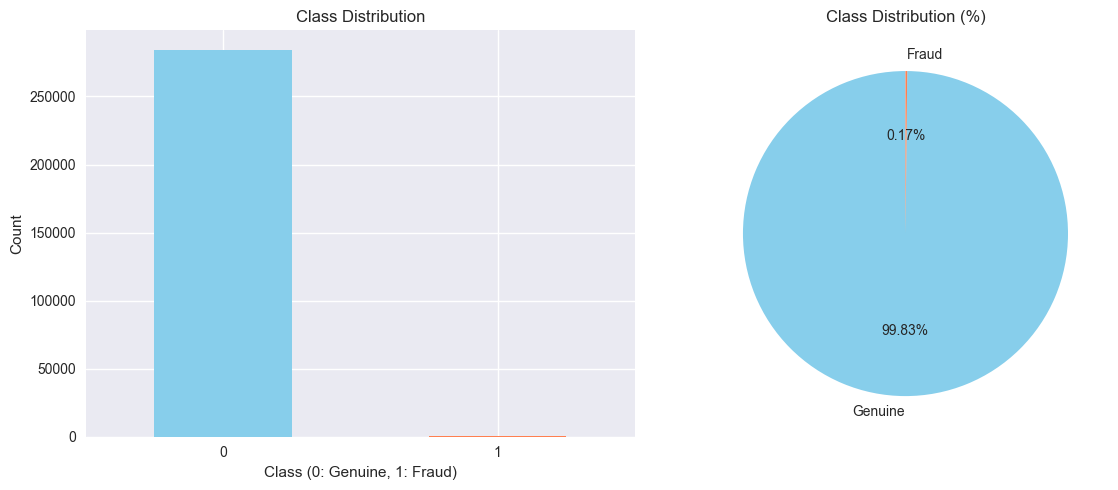


⚡ FAST Hyperparameter Tuning
🔍 Testing 12 parameter combinations (Fast Mode)...
📊 Format: KNN: k=X, weights=Y, p=Z | F1: A, Precision: B, Recall: C
----------------------------------------------------------------------
🤖 KNN: k=1, weights=uniform, p=2 | F1: 0.8254, Precision: 0.8571, Recall: 0.7959
🎉 *** New best! ***
🤖 KNN: k=1, weights=distance, p=2 | F1: 0.8254, Precision: 0.8571, Recall: 0.7959
🤖 KNN: k=3, weights=uniform, p=2 | F1: 0.8539, Precision: 0.9500, Recall: 0.7755
🎉 *** New best! ***
🤖 KNN: k=3, weights=distance, p=2 | F1: 0.8539, Precision: 0.9500, Recall: 0.7755
🤖 KNN: k=5, weights=uniform, p=2 | F1: 0.8380, Precision: 0.9259, Recall: 0.7653
🤖 KNN: k=5, weights=distance, p=2 | F1: 0.8380, Precision: 0.9259, Recall: 0.7653
🤖 KNN: k=7, weights=uniform, p=2 | F1: 0.8249, Precision: 0.9241, Recall: 0.7449
🤖 KNN: k=7, weights=distance, p=2 | F1: 0.8475, Precision: 0.9494, Recall: 0.7653
🤖 KNN: k=9, weights=uniform, p=2 | F1: 0.7910, Precision: 0.8861, Recall: 0.7143
🤖 KNN: 

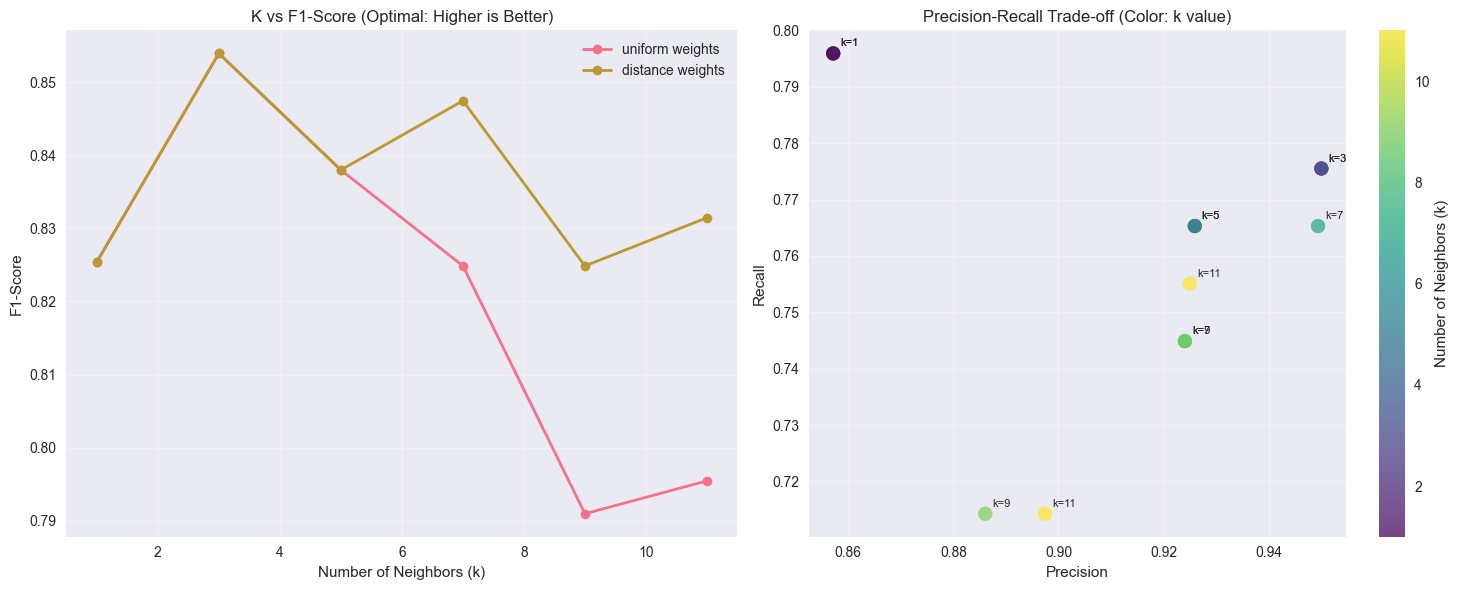


🎯 Training final model with best parameters: k=3, weights=uniform, p=2


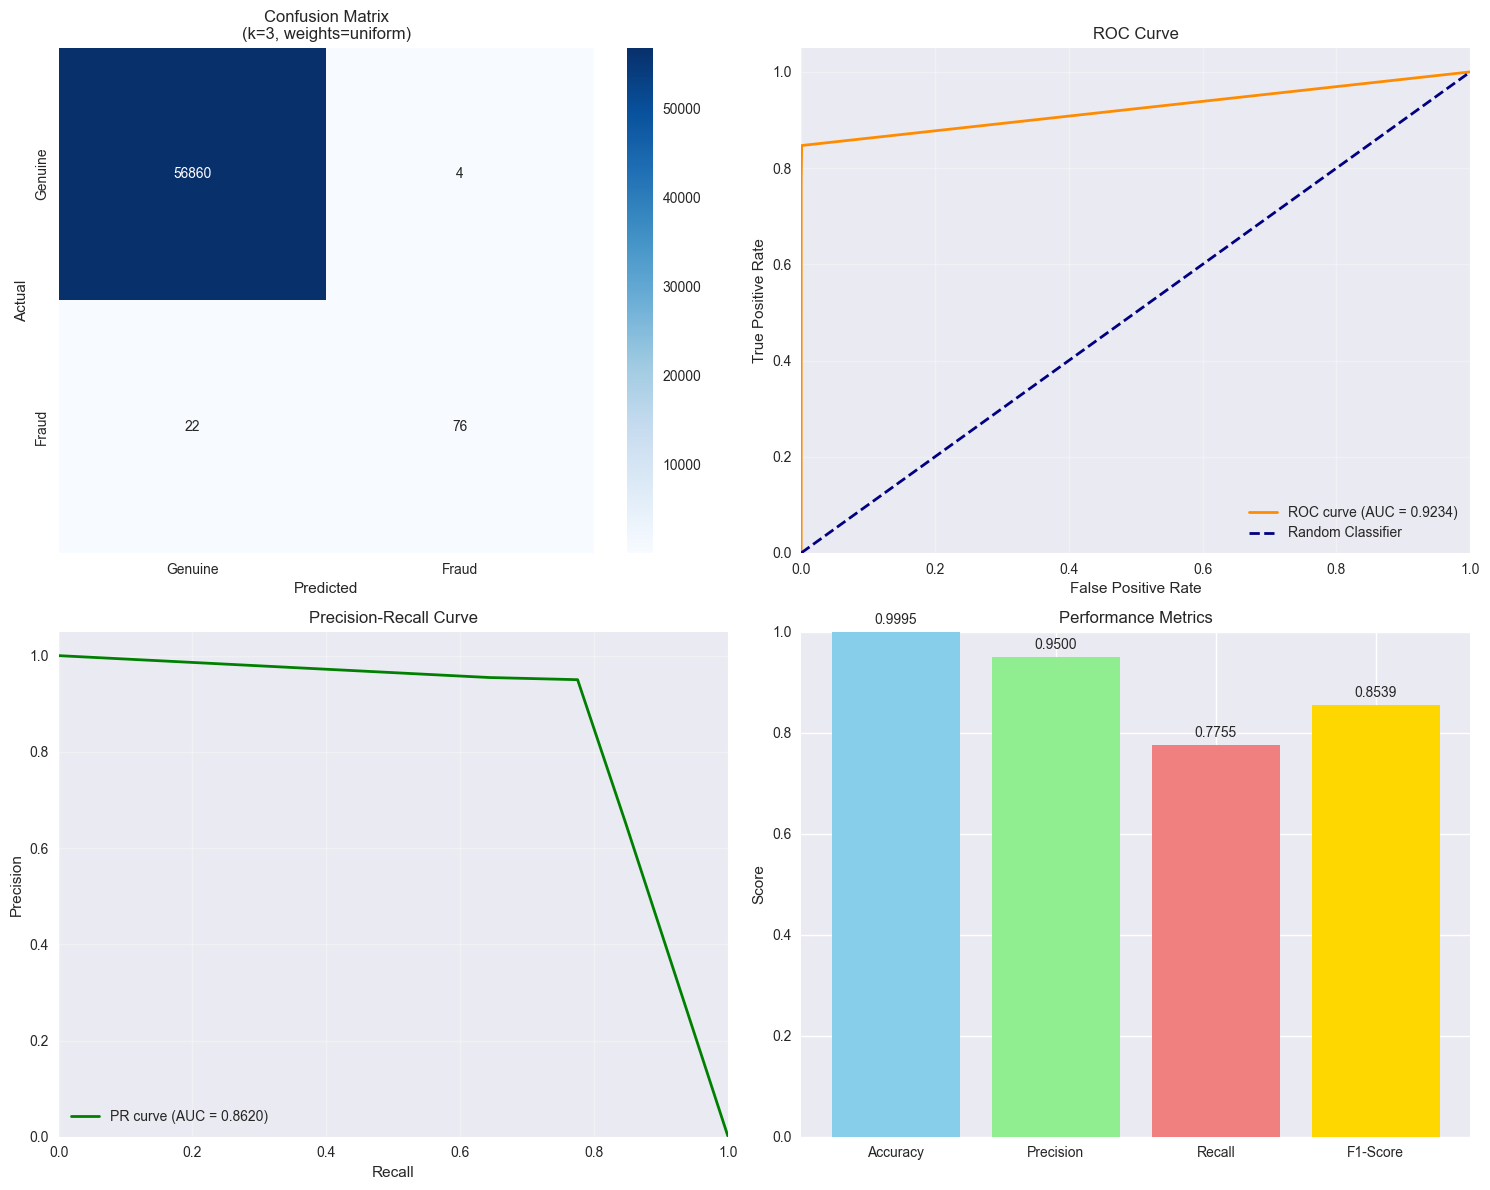


📊 FINAL COMPREHENSIVE REPORT
🎯 Best Parameters: k=3, weights=uniform, p=2

📈 Cross-validation Scores (3-fold):
F1:       0.8127 (+/- 0.0359)
Accuracy: 0.9994 (+/- 0.0001)
Precision: 0.9163 (+/- 0.0839)
Recall:    0.7310 (+/- 0.0295)

🧪 Test Set Performance:
Accuracy:  0.9995
Precision: 0.9500
Recall:    0.7755
F1-Score:  0.8539

🎉 EXECUTION SUMMARY
✅ Fast hyperparameter tuning completed
✅ Optimal KNN parameters found
✅ Comprehensive visualizations generated
✅ Performance metrics calculated
✅ Best model: k=3, weights=uniform, p=2
✅ Best F1-Score: 0.8539
🎊 All steps completed successfully!


In [3]:
# Cell 3: Run the Complete Pipeline
print("🚀 Starting Credit Card Fraud Detection with KNN...")

# Initialize the fraud detection system
fraud_detector = CreditCardFraudDetectionKNNFast()

# Create directories first
fraud_detector.create_directories()

# Load and preprocess data
fraud_detector.load_data()

# Analyze class imbalance
fraud_detector.analyze_class_imbalance()

# Perform FAST hyperparameter tuning
best_params = fraud_detector.hyperparameter_tuning_fast()

# Plot fast analysis
fraud_detector.plot_fast_analysis()

# Plot final results
fraud_detector.plot_final_results()

# Print final report
fraud_detector.print_final_report()

# Print summary
print("\n" + "="*60)
print("🎉 EXECUTION SUMMARY")
print("="*60)
print("✅ Fast hyperparameter tuning completed")
print("✅ Optimal KNN parameters found")
print("✅ Comprehensive visualizations generated")
print("✅ Performance metrics calculated")
print(f"✅ Best model: k={best_params['n_neighbors']}, "
      f"weights={best_params['weights']}, p={best_params['p']}")
print(f"✅ Best F1-Score: {best_params['results']['test_f1']:.4f}")

print("🎊 All steps completed successfully!")